In [106]:
import requests
import urllib3
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import time
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import stravalib

import polyline

import folium

pd.set_option("display.max_columns", 100)


Interesting link: https://towardsdatascience.com/using-the-strava-api-and-pandas-to-explore-your-activity-data-d94901d9bfde
Strava API forum: https://groups.google.com/g/strava-api

In [3]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

auth_url = "https://www.strava.com/oauth/token"
payload = {
    'client_id': "75483",
    'client_secret': 'd7d1e5483201559ddf62c677ac12f6cf7847c5ae',
    'refresh_token': '75994cf8182a3b6a956390b5a4da3eba764f1d85',
    'grant_type': "refresh_token",
    'f': 'json',
}

In [4]:
print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
print("Access Token = {}\n".format(access_token))

Requesting Token...

Access Token = 3519aa1c85eb561139e5a1c68e2dbc71792a24f7



In [69]:
activites_url = "https://www.strava.com/api/v3/athlete/activities"

dataset=[]
pages_count=1

while pages_count>0:
    header = {'Authorization': 'Bearer ' + access_token}
    param = {'per_page': 200, 'page': pages_count}
    my_dataset=requests.get(activites_url, headers=header, params=param).json()
    if my_dataset==[]:
        break
    elif my_dataset!=[]:
        dataset.append(my_dataset)
        pages_count+=1
dataset = [j for i in dataset for j in i]


In [95]:
activities = pd.json_normalize(dataset)
activities.columns

Index(['resource_state', 'name', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'type', 'workout_type', 'id', 'start_date',
       'start_date_local', 'timezone', 'utc_offset', 'location_city',
       'location_state', 'location_country', 'achievement_count',
       'kudos_count', 'comment_count', 'athlete_count', 'photo_count',
       'trainer', 'commute', 'manual', 'private', 'visibility', 'flagged',
       'gear_id', 'start_latlng', 'end_latlng', 'start_latitude',
       'start_longitude', 'average_speed', 'max_speed', 'average_cadence',
       'has_heartrate', 'average_heartrate', 'max_heartrate',
       'heartrate_opt_out', 'display_hide_heartrate_option', 'elev_high',
       'elev_low', 'upload_id', 'upload_id_str', 'external_id',
       'from_accepted_tag', 'pr_count', 'total_photo_count', 'has_kudoed',
       'suffer_score', 'athlete.id', 'athlete.resource_state', 'map.id',
       'map.summary_polyline', 'map.resource_state', 'average_watts',
       '

In [99]:
#Create new dataframe with only columns I care about
cols =['name',
          'start_date_local',
          'id',
          'type',
          'distance',
          'moving_time',
          'elapsed_time',
          'total_elevation_gain',
          'elev_high',
          'elev_low',
          'average_speed',
          'max_speed',
          'average_heartrate',
          'max_heartrate',
          'start_latitude',
          'start_longitude']

activities = activities[cols]
"""
# Convert dates to datetime type
activities['start_date_local']= [datetime.strptime(i,"%Y-%m-%dT%H:%M:%SZ") for i in activities['start_date_local']]
activities['start_time']=[time(hour=i.hour,minute=i.minute,second=i.second) for i in activities['start_date_local']]
activities['start_date_local'] =[date(year=i.year,month=i.month,day=i.day) for i in activities['start_date_local']]
"""
# Create a distance in km column
activities['distance_km'] = activities['distance']/1000

# Convert dates to datetime type
activities['start_date_local'] = pd.to_datetime(activities['start_date_local'])

# Create a day of the week and month of the year columns
activities['day_of_week'] = activities['start_date_local'].dt.day_name()
activities['month_of_year'] = activities['start_date_local'].dt.month
# Convert times to timedeltas
activities['moving_time'] = pd.to_timedelta(activities['moving_time'])
activities['elapsed_time'] = pd.to_timedelta(activities['elapsed_time'])
# Convert timings to hours for plotting
activities['elapsed_time_hr'] = activities['elapsed_time'].view(int)/3600
activities['moving_time_hr'] = activities['moving_time'].view(int)/3600

activities.head()

,name,start_date_local,id,type,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,average_speed,max_speed,average_heartrate,max_heartrate,start_latitude,start_longitude,distance_km,day_of_week,month_of_year,elapsed_time_hr,moving_time_hr
0,Afternoon Run,2022-02-09 17:12:44+00:00,6656698791,Run,8001.9,0 days 00:00:00.000002563,0 days 00:00:00.000002611,143.5,668.5,640.4,3.122,4.753,153.2,190.0,40.394094,-3.762571,8.0019,Wednesday,2,0.725278,0.711944
1,Afternoon Run,2022-02-07 17:35:18+00:00,6646079714,Run,11011.4,0 days 00:00:00.000003331,0 days 00:00:00.000003389,91.8,668.7,600.9,3.306,4.243,156.9,180.0,40.393794,-3.764696,11.0114,Monday,2,0.941389,0.925278
2,Lunch Run,2022-02-06 12:27:31+00:00,6639897798,Run,10473.8,0 days 00:00:00.000003388,0 days 00:00:00.000003388,142.4,678.7,626.2,3.091,3.948,162.8,185.0,40.394039,-3.760392,10.4738,Sunday,2,0.941111,0.941111
3,Afternoon Run,2022-02-02 16:51:47+00:00,6620758476,Run,6006.5,0 days 00:00:00.000002101,0 days 00:00:00.000002106,81.1,668.8,636.1,2.859,3.828,153.9,174.0,40.394120,-3.764363,6.0065,Wednesday,2,0.585000,0.583611
4,Carrera de tarde,2022-01-31 17:33:51+00:00,6610645421,Run,12400.0,0 days 00:00:00.000003695,0 days 00:00:00.000003695,163.5,670.3,626.2,3.356,13.716,NaN,NaN,40.393962,-3.760712,12.4000,Monday,1,1.026389,1.026389


In [86]:
activities['type'].value_counts()


Ride              170
Run               123
Swim               83
Hike               50
Workout             2
BackcountrySki      1
Name: type, dtype: int64

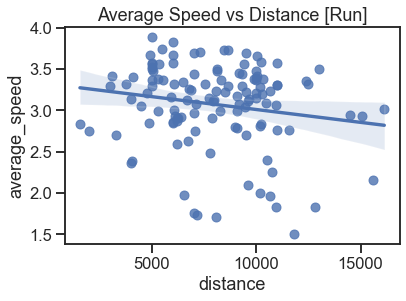

In [87]:
runs = activities.loc[activities['type'] == 'Run']
sns.set(style="ticks", context="talk")
sns.regplot(x='distance', y = 'average_speed', data = runs).set_title("Average Speed vs Distance [Run]");
#Units are meters per second!

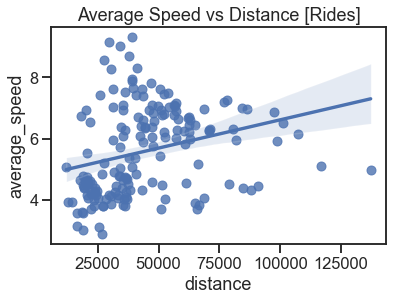

In [88]:
rides = activities.loc[activities['type'] == 'Ride']
sns.set(style="ticks", context="talk")
sns.regplot(x='distance', y = 'average_speed', data = rides).set_title("Average Speed vs Distance [Rides]");


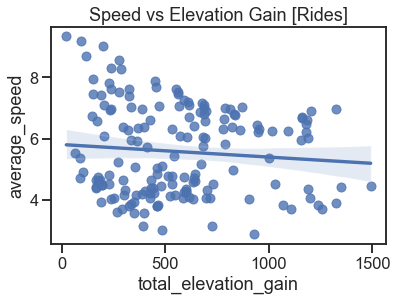

In [89]:
rides_filtered = rides.loc[(rides['total_elevation_gain'] < 1500)]
sns.regplot(x='total_elevation_gain', y = 'average_speed', data = rides_filtered).set_title("Speed vs Elevation Gain [Rides]");


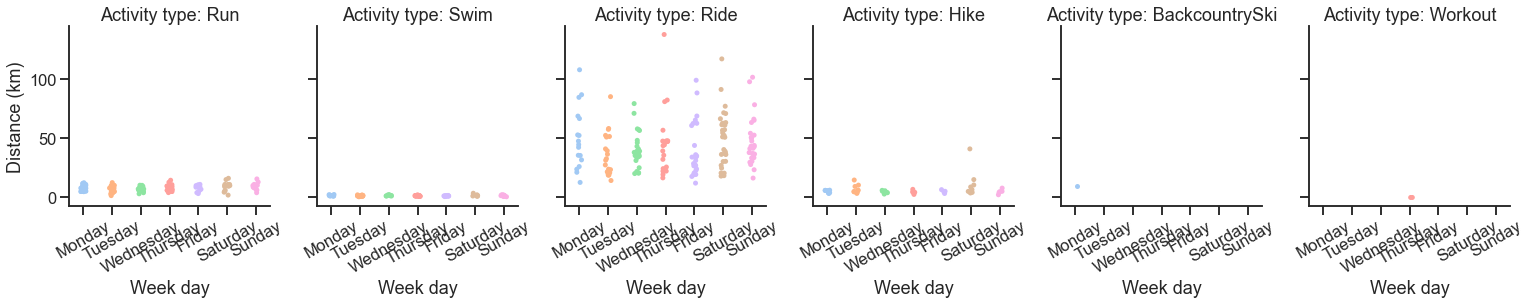

In [92]:
day_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday' ]
g = sns.catplot(x='day_of_week', y='distance_km', kind='strip', data=activities, order=day_of_week_order, col='type', height=4, aspect=0.9, palette='pastel')
(g.set_axis_labels("Week day", "Distance (km)")
  .set_titles("Activity type: {col_name}")
  .set_xticklabels(rotation=30));

In [111]:
activities_map = pd.json_normalize(dataset)

latlon=polyline.decode(activities_map['map.summary_polyline'][0])

In [128]:
mapit = None
for coord in latlon:
    mapit = folium.Map( location=[ coord[0], coord[1] ] )

folium.PolyLine(latlon,
                color='red',
                weight=3,
                opacity=0.8).add_to(mapit)

mapit.save( 'map.html')

mapit

### Get the maps of the routes
https://developers.google.com/maps/documentation/utilities/polylineutility